# Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential

# Sklearn
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import os
import time
import random
import numpy as np

import seaborn as sns
import librosa.display

from tabulate import tabulate
import matplotlib.pyplot as plt


# Q1. Feedforward Neural Network


## Load Mfccs

In [ ]:
#import mfccs data
def load_mfccs(path):

  ''' Given the mfccs train folder path loads all needed data from the other folders  '''

  folderDict = {"train": None, "test": None, "val": None}
  prev_folder = "train"
  for folder in folderDict.keys():

      X_path = path.replace(prev_folder, folder) + "/X.npy"
      labels_path = path.replace(prev_folder, folder) + "/labels.npy"

      # convert labels from str ---> int
      X = np.load(X_path)
      X = np.float32(X)   # convert to float32 cause np = float64 whereas tensor = float32
      labels = np.load(labels_path)
      unique_labels, conv_labels = np.unique(labels, return_inverse=True)

      #load to folder dict
      folderDict[folder] = (X, conv_labels)
      prev_folder = folder

  data_files = folderDict

  X_train, labels_train = data_files["train"]
  X_test, labels_test = data_files["test"]
  X_val, labels_val = data_files["val"]

  # return as tuples
  return (X_train, labels_train), (X_test, labels_test), (X_val, labels_val)


# Define custom dataset
class Mfccs_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label


# Load files given the train/mfccs  folder
path  = "/content/drive/MyDrive/ML2_data/music_genre_data_di/train/mfccs"
train_data, test_data, val_data = load_mfccs(path)

# decompose data tuple
X_train, labels_train = train_data
X_test, labels_test =  test_data
X_val, labels_val = val_data

# load as Datasets
train_dataset = Mfccs_Dataset(X_train, labels_train)
test_dataset = Mfccs_Dataset(X_test, labels_test)
val_dataset = Mfccs_Dataset(X_val, labels_val)

# load to Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


## Define FFN Model

In [ ]:
class FNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN, self).__init__()

        self.layer_1 = nn.Linear(input_dim, hidden_dim[0])
        self.layer_2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.layer_3 = nn.Linear(hidden_dim[1], output_dim)

    def forward(self, x):
        out1 = self.layer_1(x)
        out2 = self.layer_2(out1)
        out3 = self.layer_3(out2)
        return out3

# Initialize FNN model
device = torch.device('cpu')

input_dim = 26
output_dim = 4
hidden_dimensions = [128, 32]

model = FNN(input_dim, hidden_dimensions, output_dim).to(device)

## Define Trainning Procedure

In [ ]:
def training(epochs, optimizer, dataloader, loss_fn, model, device, val_dataloader=None, print_loss=None, print_diff=None):

    ''' Returns trained model or diff bettween train and validation loss  and prints loss for each epoch /
        if validation dataloader is given returns best model selected  '''

    epoch_losses = []
    best_f1_score = -1
    no_improvement = 0
    no_improvement_tolerance = 8
    diff_losses = []

    for epoch in range(epochs):

        model.train()
        batch_losses = []
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            # clear gradients  parameters
            optimizer.zero_grad()

            # predict
            outputs = model(x)
            loss = loss_fn(outputs, y)

            # getting gradients  parameters
            loss.backward()

            # update parameters
            optimizer.step()

            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)

        # model selection
        if val_dataloader:
            eval_losses, current_f1_score, _, _ = evaluation(val_dataloader, loss_fn, model, device)
            if print_diff:
              diff_losses.append(abs(eval_losses - loss.item()))

            if current_f1_score > best_f1_score:
                best_f1_score = current_f1_score
                torch.save(model.state_dict(), "best_model")
                no_improvement = 0
            else:
                no_improvement += 1
            # if f1_score keeps getting worse for more tha no_improvement_tolerance stop trainning
            if no_improvement >= no_improvement_tolerance:
                print(f"Improvement fall down occured at {epoch + 1} epoch")
                break

    if print_loss:
        print(tabulate(enumerate(epoch_losses, start=1), headers=["Epoch", "Loss"], tablefmt="github"))

    return model, diff_losses


## Define Evaluation Procedure

In [ ]:
def evaluation(dataloader, loss_fn, model, device):
    model.eval()
    batch_losses = []
    all_predictions = []
    all_true = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            # predict and calculate loss
            outputs = model(x)
            loss = loss_fn(outputs, y)
            batch_losses.append(loss.item())

            preds = outputs.argmax(dim=1)
            all_predictions.extend(preds.cpu().numpy())
            all_true.extend(y.cpu().numpy())

    mean_loss = np.mean(batch_losses)
    macro_score = f1_score(all_true, all_predictions, average='macro', zero_division=1)
    accuracy = accuracy_score(all_true, all_predictions)
    cfm = confusion_matrix(all_true, all_predictions)

    model.train()

    return mean_loss, macro_score, accuracy, cfm


## Model Trainning with CPU

In [ ]:
device = 'cpu'

learning_rate = 0.002
loss_func = nn.CrossEntropyLoss()
epochs_num = 30
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

start_time = time.time()
trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, print_loss=True)
end_time = time.time()

cpu_time = end_time - start_time

test_losses, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Loss: {np.mean(test_losses)} " )
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)


|   Epoch |     Loss |
|---------|----------|
|       1 | 1.37299  |
|       2 | 1.34726  |
|       3 | 1.32026  |
|       4 | 1.30047  |
|       5 | 1.27653  |
|       6 | 1.25177  |
|       7 | 1.22704  |
|       8 | 1.19591  |
|       9 | 1.17161  |
|      10 | 1.14605  |
|      11 | 1.11963  |
|      12 | 1.09927  |
|      13 | 1.08137  |
|      14 | 1.06096  |
|      15 | 1.04667  |
|      16 | 1.03777  |
|      17 | 1.01947  |
|      18 | 1.00615  |
|      19 | 0.995799 |
|      20 | 0.996423 |
|      21 | 0.987697 |
|      22 | 0.972534 |
|      23 | 0.974414 |
|      24 | 0.96754  |
|      25 | 0.956685 |
|      26 | 0.962046 |
|      27 | 0.947147 |
|      28 | 0.944495 |
|      29 | 0.935298 |
|      30 | 0.936546 |

REPORT:
Mean Loss: 0.951451342119727 
F1 Macro Score: 0.6028480657690185
Accracy: 0.6271802325581395
Confusion Matrix:
[[ 72  28 123 101]
 [ 30 238  20   9]
 [ 30  14 299  13]
 [ 43  37  65 254]]


## Model Trainning with GPU

In [ ]:
device = "mps" if getattr(torch, 'has_mps', False) \
          else "cuda" if torch.cuda.is_available() \
          else "cpu"

# Initialize model and optimizer
model = FNN(input_dim, hidden_dimensions, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Measure training time on GPU
start_time = time.time()
trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, print_loss=True)
end_time = time.time()

gpu_time = end_time - start_time

# Print CPU and GPU training times
print(f"CPU Time: {cpu_time}")
print(f"GPU Time: {gpu_time}\n")

# Evaluate the model
test_losses, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Loss: {np.mean(test_losses)} " )
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)

<ipython-input-8-ad2676cf714a>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \


|   Epoch |     Loss |
|---------|----------|
|       1 | 1.39692  |
|       2 | 1.37507  |
|       3 | 1.3604   |
|       4 | 1.34146  |
|       5 | 1.32133  |
|       6 | 1.30427  |
|       7 | 1.28014  |
|       8 | 1.2551   |
|       9 | 1.22752  |
|      10 | 1.20523  |
|      11 | 1.18135  |
|      12 | 1.15216  |
|      13 | 1.13206  |
|      14 | 1.11501  |
|      15 | 1.09493  |
|      16 | 1.07291  |
|      17 | 1.06119  |
|      18 | 1.04625  |
|      19 | 1.02806  |
|      20 | 1.01985  |
|      21 | 1.00976  |
|      22 | 1.00013  |
|      23 | 0.987438 |
|      24 | 0.986773 |
|      25 | 0.977385 |
|      26 | 0.962179 |
|      27 | 0.955855 |
|      28 | 0.953749 |
|      29 | 0.951697 |
|      30 | 0.946911 |
CPU Time: 5.7926435470581055
GPU Time: 7.477564334869385


REPORT:
Mean Loss: 0.9859579427297726 
F1 Macro Score: 0.6088978331634811
Accracy: 0.6039244186046512
Confusion Matrix:
[[130   8  95  91]
 [ 85 183  14  15]
 [ 70   6 264  16]
 [ 86   8  51 254]]


## Model Selection

In [ ]:
device = 'cpu'

model = FNN(input_dim, hidden_dimensions, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader, print_loss=True)

test_losses, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Loss: {np.mean(test_losses)} " )
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)


Improvement fall down occured at 22 epoch
|   Epoch |     Loss |
|---------|----------|
|       1 | 1.39225  |
|       2 | 1.36144  |
|       3 | 1.33979  |
|       4 | 1.31365  |
|       5 | 1.2883   |
|       6 | 1.26075  |
|       7 | 1.23598  |
|       8 | 1.20634  |
|       9 | 1.1784   |
|      10 | 1.15     |
|      11 | 1.11899  |
|      12 | 1.10058  |
|      13 | 1.07022  |
|      14 | 1.05438  |
|      15 | 1.03869  |
|      16 | 1.02134  |
|      17 | 1.00553  |
|      18 | 0.991898 |
|      19 | 0.985528 |
|      20 | 0.977852 |
|      21 | 0.966294 |
|      22 | 0.956703 |

REPORT:
Mean Loss: 0.9775539291805999 
F1 Macro Score: 0.5985160407717371
Accracy: 0.6242732558139535
Confusion Matrix:
[[ 63  20 155  86]
 [ 36 227  22  12]
 [ 20  10 316  10]
 [ 49  22  75 253]]


# Q2. Convolutional Neural Network


## Load Melgrams

In [ ]:
def load_melgrams(path):

    folderDict = {"train": None, "test": None, "val": None}

    for folder in folderDict.keys():
        folder_path = path.replace("train", folder)
        X_path = os.path.join(folder_path, "X.npy")
        labels_path = os.path.join(folder_path, "labels.npy")

        X = np.load(X_path)
        X = np.float32(X)
        labels = np.load(labels_path)

        unique_labels, conv_labels = np.unique(labels, return_inverse=True)

        folderDict[folder] = (X, conv_labels)

    X_train, labels_train = folderDict["train"]
    X_test, labels_test = folderDict["test"]
    X_val, labels_val = folderDict["val"]

    return (X_train, labels_train), (X_test, labels_test), (X_val, labels_val)

# define custom dataset  melgrams
class Melgrams_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data[:, np.newaxis, :, :])
        self.labels = torch.from_numpy(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

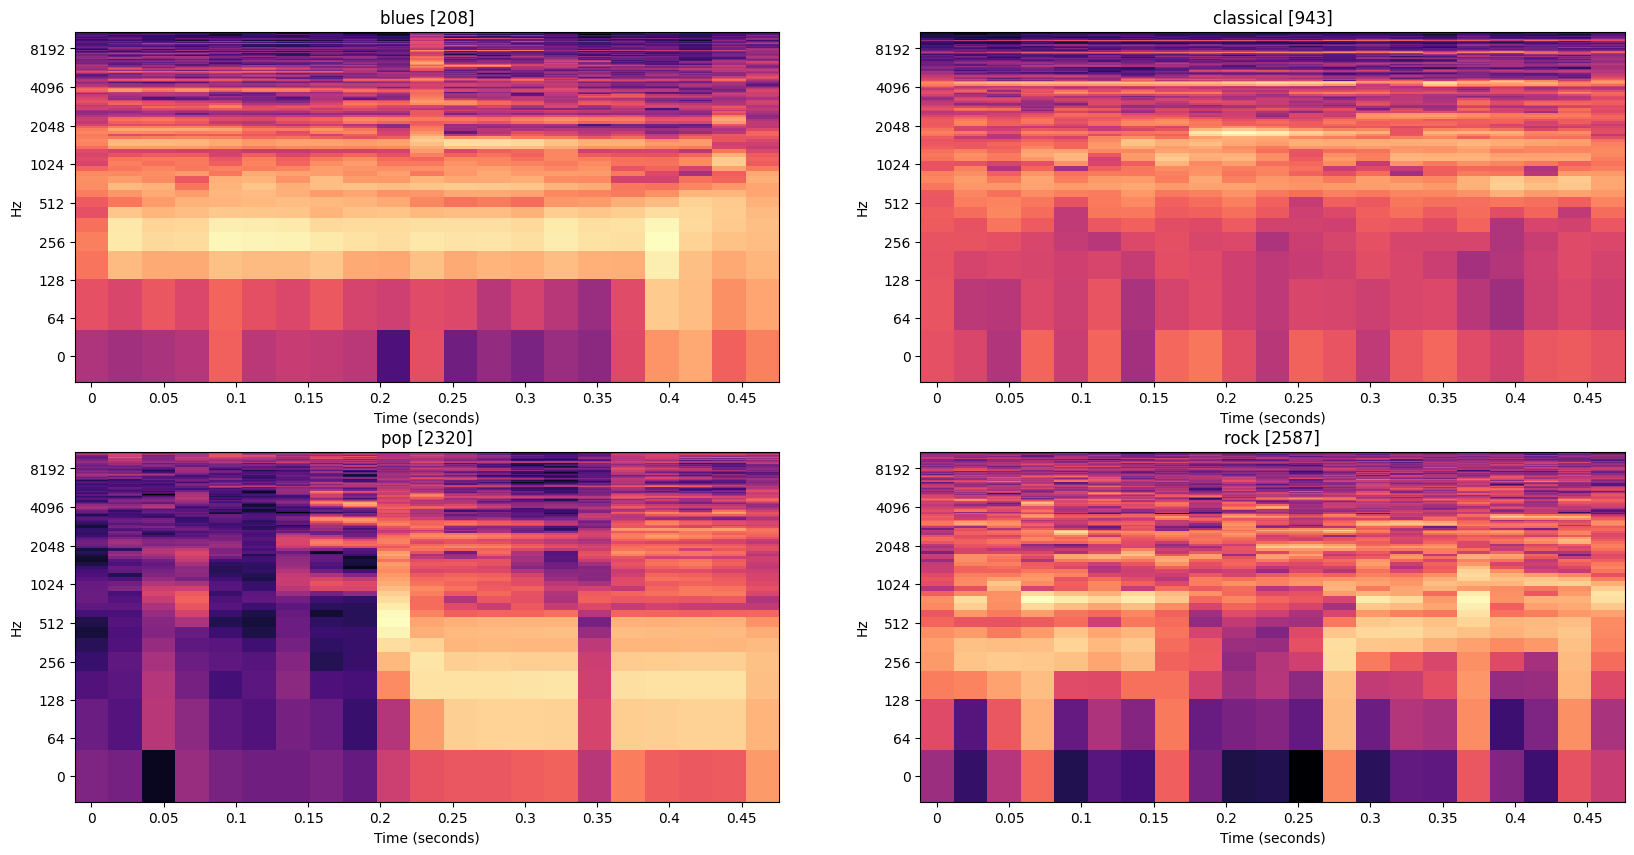

In [ ]:
# Load data giving train melgrams folder
path = "/content/drive/MyDrive/ML2_data/music_genre_data_di/train/melgrams"
(train_data, train_labels), (test_data, test_labels), (val_data, val_labels) = load_melgrams(path)

labels_dict = {0: "blues", 1: "classical", 2: "pop", 3: "rock"}

# load as Datasets
train_dataset = Melgrams_Dataset(train_data, train_labels)
val_dataset = Melgrams_Dataset(val_data, val_labels)
test_dataset = Melgrams_Dataset(test_data, test_labels)

# load to dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16)

# Visualize a random melgram from each genre
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, genre in enumerate(np.unique(train_labels)):
    genre_indices = np.where(train_labels == genre)[0]
    rand_index = random.choice(genre_indices)
    librosa.display.specshow(train_data[rand_index].T, ax=axs[i], x_axis='s', y_axis='log')
    axs[i].set_title(f"{labels_dict[genre]} [{rand_index}]")

plt.show()


## Define CNN Model

In [ ]:

class CNN(nn.Module):
    def __init__(self, num_classes, kernel_size=5, padding=0, stride=1, pooling=False, pooling_kernel_size=2, activation_function=None, batch_norm=False, dropout=None):
        super(CNN, self).__init__()

        self.pooling = pooling
        self.activation_function = activation_function
        self.batch_norm = batch_norm

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(1, 16, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding, stride=stride)
        ])

        self.batch_norm_layers = nn.ModuleList([
            nn.BatchNorm2d(16),
            nn.BatchNorm2d(32),
            nn.BatchNorm2d(64),
            nn.BatchNorm2d(128)
        ])

        self.flatten = nn.Flatten()

        height, width = 21, 128
        for _ in range(4):
            height = (height - kernel_size + 2 * padding) / stride + 1
            width = (width - kernel_size + 2 * padding) / stride + 1
            if pooling:
                height = (height - pooling_kernel_size) // pooling_kernel_size + 1
                width = (width - pooling_kernel_size) // pooling_kernel_size + 1

        conv_output_dim = int(height * width * 128)

        self.dropout_value = dropout
        if dropout:
            self.dropout = nn.Dropout(dropout)

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_dim, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)
            if self.batch_norm:
                x = self.batch_norm_layers[i](x)
            if self.activation_function:
                x = self.activation_function(x)
            if self.pooling:
                x = F.max_pool2d(x, kernel_size=2)

        x = self.flatten(x)

        for fc_layer in self.fc_layers:
            x = fc_layer(x)
            if self.activation_function:
                x = self.activation_function(x)
            if self.dropout_value:
                x = self.dropout(x)

        return x

# Initialize CNN Model
output_dim = 4
model = CNN(num_classes=output_dim, kernel_size=5, padding=0, stride=1, pooling=False, pooling_kernel_size=2,
            activation_function=None, batch_norm=True, dropout=None)


## Train Model

In [ ]:

device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
model = CNN(num_classes=output_dim, kernel_size=5, padding=0, stride=1, pooling=False, pooling_kernel_size=2, activation_function=None, batch_norm=False, dropout=None).to(device)
learning_rate = 0.002
loss_func = nn.CrossEntropyLoss()
epochs_num = 30
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train
start_time = time.time()
trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader=None, print_loss=True)
end_time = time.time()

gpu_time = end_time - start_time
print(f"Training time on GPU: {gpu_time} seconds")

# Evaluate
test_losses, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Loss: {np.mean(test_losses)} " )
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)

<ipython-input-13-cc50452b0b2e>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"


|   Epoch |   Loss |
|---------|--------|
|       1 |    nan |
|       2 |    nan |
|       3 |    nan |
|       4 |    nan |
|       5 |    nan |
|       6 |    nan |
|       7 |    nan |
|       8 |    nan |
|       9 |    nan |
|      10 |    nan |
|      11 |    nan |
|      12 |    nan |
|      13 |    nan |
|      14 |    nan |
|      15 |    nan |
|      16 |    nan |
|      17 |    nan |
|      18 |    nan |
|      19 |    nan |
|      20 |    nan |
|      21 |    nan |
|      22 |    nan |
|      23 |    nan |
|      24 |    nan |
|      25 |    nan |
|      26 |    nan |
|      27 |    nan |
|      28 |    nan |
|      29 |    nan |
|      30 |    nan |
Training time on GPU: 103.51880598068237 seconds

REPORT:
Mean Loss: nan 
F1 Macro Score: 0.09529411764705882
Accracy: 0.23546511627906977
Confusion Matrix:
[[324   0   0   0]
 [297   0   0   0]
 [356   0   0   0]
 [399   0   0   0]]


Παρατηρουμε οτι το δικτυο δεν μπορει να εκπεδευτει αφου το σφαλμα αυξανεται συνεχως.

Βλεπουμε οτι με χρηση CPU ο χρονος εκτελεσης ειναι πολυ μεγαλυτερος σε σχεση με το προηγουμενο ερωτημα (1 ωρα +) ενω με GPU ειναι ισος με καποια δευτερολεπτα.Σε συγκριση με το προηγουμε ερωτημα η αναλογια εναι εντελως διαφορετικη.Στη πρωτη περιπτωση ο χρονος εκτελεσης με cpu ειναι μικροτερος απο αυτον της gpu (αφου το δικτυο ειναι αρκετα πιο απλο και τα δεδομενα οχι τοσο συνθετα δεν υπαρχει αναγκη για παραλληλο προγραμματισμο).Στην δευτερη περιπτωση το δικτυο ειναι αρκετα πιο συνθετο και μεγαλο οποτε η gpu εδω μας οφελει.

## Pooling and Padding

In [ ]:
device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
model = CNN(num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
    activation_function=None, batch_norm=False, dropout=None).to(device)

learning_rate = 0.002
loss_func = nn.CrossEntropyLoss()
epochs_num = 30
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train
trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader=None, print_loss=True)

print(f"Training time on GPU: {gpu_time} seconds")

# Evaluate
test_losses, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Loss: {np.mean(test_losses)} " )
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)


<ipython-input-14-6d575c74553c>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"


|   Epoch |      Loss |
|---------|-----------|
|       1 | 1.33563   |
|       2 | 1.19715   |
|       3 | 1.05311   |
|       4 | 0.937898  |
|       5 | 0.862271  |
|       6 | 0.803576  |
|       7 | 0.748149  |
|       8 | 0.702496  |
|       9 | 0.670583  |
|      10 | 0.650416  |
|      11 | 0.596629  |
|      12 | 0.588547  |
|      13 | 0.544138  |
|      14 | 0.513999  |
|      15 | 0.472213  |
|      16 | 0.44061   |
|      17 | 0.411735  |
|      18 | 0.381659  |
|      19 | 0.338324  |
|      20 | 0.305224  |
|      21 | 0.258939  |
|      22 | 0.226683  |
|      23 | 0.180785  |
|      24 | 0.144565  |
|      25 | 0.106691  |
|      26 | 0.210492  |
|      27 | 0.0789136 |
|      28 | 0.0455085 |
|      29 | 0.0321238 |
|      30 | 0.0207702 |
Training time on GPU: 103.51880598068237 seconds

REPORT:
Mean Loss: 1.192884228255892 
F1 Macro Score: 0.7374698710355782
Accracy: 0.7303779069767442
Confusion Matrix:
[[196   8  33  87]
 [ 21 264   4   8]
 [ 35   5 274  42]
 [ 76 

Max Pooling: Η λειτουργεια αυτη πραγματοποιει down sampling στο feature map επιλεγοντας τα πιο σημαντικα χαρακτηριστικα.

Padding: Πραγματοποιειται μετα το pooling και ειναι η προσθηκη επιπλεον μηδενικων πριν απο την συνελιξη στο feature map.

F1 Score = 70%

Accracy = 70%

Επομενως, οι συγκεκριμενες τεχνικες ειναι σημαντικα χρησιμες αφου οι επιδοσεις του μοντελου μας αυξηθηκαν

## Activation Functions

In [ ]:
device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
model = CNN(num_classes=output_dim, kernel_size=5, padding=0, stride=1, pooling=False, pooling_kernel_size=2,
    activation_function=F.relu, batch_norm=False, dropout=None).to(device)

learning_rate = 0.002
loss_func = nn.CrossEntropyLoss()
epochs_num = 30
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train
trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader=None, print_loss=True)

# Evaluate
test_losses, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Loss: {np.mean(test_losses)} " )
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)

<ipython-input-15-3da2a9d66288>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"


|   Epoch |       Loss |
|---------|------------|
|       1 | 1.3444     |
|       2 | 1.25561    |
|       3 | 1.19631    |
|       4 | 1.16451    |
|       5 | 1.13672    |
|       6 | 1.08645    |
|       7 | 1.03419    |
|       8 | 1.03193    |
|       9 | 0.963058   |
|      10 | 0.88734    |
|      11 | 0.827183   |
|      12 | 0.788268   |
|      13 | 0.760785   |
|      14 | 0.706012   |
|      15 | 0.68801    |
|      16 | 0.613165   |
|      17 | 0.552143   |
|      18 | 0.520094   |
|      19 | 0.444825   |
|      20 | 0.395777   |
|      21 | 0.310424   |
|      22 | 0.331509   |
|      23 | 0.304695   |
|      24 | 0.154787   |
|      25 | 0.110259   |
|      26 | 0.102494   |
|      27 | 0.126085   |
|      28 | 0.0753793  |
|      29 | 0.017557   |
|      30 | 0.00670833 |

REPORT:
Mean Loss: 2.310288435259027 
F1 Macro Score: 0.6322077413504523
Accracy: 0.6293604651162791
Confusion Matrix:
[[150  26  52  96]
 [ 27 239   8  23]
 [ 49  14 236  57]
 [ 67  27  64 241]]


Βλεπουμε οτι η επιλογη της συγκεκριμενης activation function δεν ειναι καλη για το μοντελο μας με τα optimisations που εχουμε επιλεξει  καθως μειωνει δραστικα τις επιδοσεις μας.  

##  Reproductabillity

In [ ]:
def torch_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

torch_seed()

## Optimizers

In [ ]:
# seed
torch_seed()

device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"

# define model
output_dim = 4
learning_rate = 0.002
loss_func = nn.CrossEntropyLoss()
epochs_num = 30

# optimizers to test
optimizers = {
    "sgd": torch.optim.SGD,
    "asgd": torch.optim.ASGD,
    "adagrad": torch.optim.Adagrad,
    "adadelta": torch.optim.Adadelta,
    "adam": torch.optim.Adam,
    "radam": torch.optim.RAdam
}

all_accuracies = []
all_f1 = []

# For each optimizer
for opt_name, opt_class in optimizers.items():

    # reinitialize model
    model = CNN(num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
        activation_function=None, batch_norm=True, dropout=0.5).to(device)

    optimizer = opt_class(model.parameters(), lr=learning_rate)

    # Train
    trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader=None, print_loss=False)

    # Evaluate
    test_loss, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

    all_accuracies.append((opt_name, accuracy, f1_macro_score))


# results
print(tabulate(all_accuracies, headers=["Optimizer", "Accuracy", "F1 score"], tablefmt="github"))



<ipython-input-17-af541f638b5f>:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"


| Optimizer   |   Accuracy |   F1 score |
|-------------|------------|------------|
| sgd         |   0.68314  |   0.669068 |
| asgd        |   0.611192 |   0.58898  |
| adagrad     |   0.751453 |   0.760288 |
| adadelta    |   0.739826 |   0.718396 |
| adam        |   0.690407 |   0.670907 |
| radam       |   0.638808 |   0.63048  |


Βλεπουμε οτι η επιλογη του optimizer επηρεαζει σημαντικα την επιδοση του μοντελου αφου οπως βλεπουμε εχουμε πιο χαμηλες αλλα  καιμεγαλυτερες επιδοσης

Ο καλυτερος στην δικη μας περιπτωση ειναι ο Adagrad

## Batch Normalisation

In [ ]:
torch_seed()

# initialize model
model = CNN(num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
            activation_function=None, batch_norm=True, dropout=None).to(device)

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train
trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader=None, print_loss=False)

# Evaluate
test_loss, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

print()
print("REPORT:")
print(f"Mean Evaluation Loss: {np.mean(test_loss)} ")
print(f"F1 Macro Score: {f1_macro_score}")
print(f"Accracy: {accuracy}")
print("Confusion Matrix:")
print(cfm)



REPORT:
Mean Evaluation Loss: 0.8955273824989871 
F1 Macro Score: 0.7862586130199154
Accracy: 0.784156976744186
Confusion Matrix:
[[205  11  40  68]
 [  8 284   1   4]
 [ 25   5 309  17]
 [ 73  13  32 281]]


## Regularization

### i) Diffrent weight decays

In [ ]:
# weight decay values a very small, the default and a larger one
weight_decays = [0.001, 0.01, 0.1]

device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"

# For each weight decay
for wd in weight_decays:
    # Initialize model
    model = CNN( num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
        activation_function=None, batch_norm=True, dropout=None).to(device)

    # optimizer
    optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate, weight_decay=wd)

    # Train
    trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader, print_loss=False, print_diff=True)

    # Evaluate
    test_loss, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

    print()
    print("REPORT:")
    print(f"Mean Evaluation Loss: {np.mean(test_loss)} ")
    print(f"F1 Macro Score: {f1_macro_score}")
    print(f"Accracy: {accuracy}")
    print("Confusion Matrix:")
    print(cfm)

<ipython-input-19-6ecebd338d61>:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"


Improvement fall down occured at 20 epoch

REPORT:
Mean Evaluation Loss: 0.6940595102306932 
F1 Macro Score: 0.7898983075250949
Accracy: 0.784156976744186
Confusion Matrix:
[[233   9  42  40]
 [ 19 274   2   2]
 [ 31   3 309  13]
 [101   6  29 263]]
Improvement fall down occured at 18 epoch

REPORT:
Mean Evaluation Loss: 0.7140467701629373 
F1 Macro Score: 0.7379038107949327
Accracy: 0.7427325581395349
Confusion Matrix:
[[136  20  27 141]
 [  1 290   0   6]
 [ 18   4 282  52]
 [ 49  18  18 314]]
Improvement fall down occured at 20 epoch

REPORT:
Mean Evaluation Loss: 0.6460082834981772 
F1 Macro Score: 0.7235926273620987
Accracy: 0.7441860465116279
Confusion Matrix:
[[104  38  30 152]
 [  1 295   0   1]
 [ 14   8 286  48]
 [ 20  21  19 339]]


### ii) Different Dropout Values

In [ ]:
# dropout values
dropout_values = [0.2, 0.5, 0.6]

for drop_val in dropout_values:
    # Initialize model
    model = CNN( num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
                activation_function=None, batch_norm=True, dropout=drop_val).to(device)

    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train
    trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader, print_loss=False)

    # Evaluate
    test_loss, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

    print(f"For drop out value = {drop_val}")
    print()
    print("REPORT:")
    print(f"Mean Evaluation Loss: {np.mean(test_loss)} ")
    print(f"F1 Macro Score: {f1_macro_score}")
    print(f"Accracy: {accuracy}")
    print("Confusion Matrix:")
    print(cfm)


Improvement fall down occured at 25 epoch
For drop out value = 0.2

REPORT:
Mean Evaluation Loss: 0.8233532421615755 
F1 Macro Score: 0.7457228617942904
Accracy: 0.7340116279069767
Confusion Matrix:
[[242  14  11  57]
 [ 33 258   0   6]
 [ 69   7 248  32]
 [116  12   9 262]]
Improvement fall down occured at 21 epoch
For drop out value = 0.5

REPORT:
Mean Evaluation Loss: 0.6574158614858725 
F1 Macro Score: 0.7653125979301605
Accracy: 0.7594476744186046
Confusion Matrix:
[[232  27   8  57]
 [  7 287   0   3]
 [ 81   8 244  23]
 [ 86  15  16 282]]
Improvement fall down occured at 27 epoch
For drop out value = 0.6

REPORT:
Mean Evaluation Loss: 0.6699051156120245 
F1 Macro Score: 0.7550897094383648
Accracy: 0.7645348837209303
Confusion Matrix:
[[142  17  79  86]
 [ 10 282   0   5]
 [ 13   2 330  11]
 [ 50   8  43 298]]


iii) 60 Epochs - Different weight decays

In [ ]:
# parameters
epochs_num = 60
output_dim = 4
learning_rate = 0.002

for wd in weight_decays:

    # Initialize model
    model = CNN( num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
        activation_function=None, batch_norm=True, dropout=None).to(device)

    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)

    # Train
    trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader, print_loss=False)

    # Evaluate
    test_loss, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)

    print(f"For weight decay = {wd}")

    print()
    print("REPORT:")
    print(f"Mean Evaluation Loss: {np.mean(test_loss)} ")
    print(f"F1 Macro Score: {f1_macro_score}")
    print(f"Accracy: {accuracy}")
    print("Confusion Matrix:")
    print(cfm)


Improvement fall down occured at 20 epoch
For weight decay = 0.001

REPORT:
Mean Evaluation Loss: 0.910134649705575 
F1 Macro Score: 0.7131712560935017
Accracy: 0.7100290697674418
Confusion Matrix:
[[192   2  87  43]
 [ 52 227  12   6]
 [ 23   3 321   9]
 [ 95  15  52 237]]
Improvement fall down occured at 25 epoch
For weight decay = 0.01

REPORT:
Mean Evaluation Loss: 0.7916578638262785 
F1 Macro Score: 0.7674875116988109
Accracy: 0.7696220930232558
Confusion Matrix:
[[156  11  27 130]
 [  8 279   1   9]
 [ 18   4 302  32]
 [ 44   9  24 322]]
Improvement fall down occured at 17 epoch
For weight decay = 0.1

REPORT:
Mean Evaluation Loss: 0.58440368224022 
F1 Macro Score: 0.7605487698341004
Accracy: 0.7667151162790697
Confusion Matrix:
[[145   9  47 123]
 [ 19 270   0   8]
 [ 18   2 310  26]
 [ 34   6  29 330]]


### iv) 60 Epochs - Different dropout values

In [ ]:
# parameters
epochs_num = 60

# Iterate through dropout values
for drop_val in dropout_values:
    # Initialize model
    model = CNN( num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
        activation_function=None, batch_norm=True, dropout=drop_val).to(device)

    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train
    trained_model, _ = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader)

    # Evaluate
    test_loss, f1_macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)


    print()
    print("REPORT:")
    print(f"Mean Evaluation Loss: {np.mean(test_loss)} ")
    print(f"F1 Macro Score: {f1_macro_score}")
    print(f"Accracy: {accuracy}")
    print("Confusion Matrix:")
    print(cfm)



Improvement fall down occured at 22 epoch

REPORT:
Mean Evaluation Loss: 0.6987087535522987 
F1 Macro Score: 0.7476673530139941
Accracy: 0.7565406976744186
Confusion Matrix:
[[134  23  30 137]
 [ 10 279   1   7]
 [ 18   3 301  34]
 [ 35  13  24 327]]
Improvement fall down occured at 19 epoch

REPORT:
Mean Evaluation Loss: 0.7423739348386609 
F1 Macro Score: 0.6902637387997402
Accracy: 0.7013081395348837
Confusion Matrix:
[[113  43  13 155]
 [  2 291   0   4]
 [ 28  10 245  73]
 [ 37  28  18 316]]
Improvement fall down occured at 22 epoch

REPORT:
Mean Evaluation Loss: 0.7162064842359964 
F1 Macro Score: 0.7349192694448188
Accracy: 0.7507267441860465
Confusion Matrix:
[[121  35  46 122]
 [  1 293   1   2]
 [ 21   8 299  28]
 [ 36  14  29 320]]


### v) 60 epochs - Different dropout values and weight decays

In [ ]:
epochs_num = 60

# Initialize variables to store the highest mean value and corresponding parameters
max_diff = -10000000.0
best_drop_val = None
best_wd = None

# Iterate through dropout values and weight decays
for drop_val in dropout_values:
    for wd in weight_decays:
        # Initialize model
        model = CNN( num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2,
                    activation_function=F.relu, batch_norm=True, dropout=drop_val).to(device)

        # Initialize optimizer
        optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate, weight_decay=wd)

        # Train the model
        trained_model, diff = training(epochs_num, optimizer, train_dataloader, loss_func, model, device, val_dataloader, print_loss=False, print_diff=True)

        # Calculate the mean of the diff list
        mean_diff = np.mean(diff)

        # Check if the current mean_diff is the highest so far
        if mean_diff > max_diff:
            max_diff = mean_diff
            best_drop_val = drop_val
            best_wd = wd

        # Evaluate the model
        test_loss, macro_score, accuracy, cfm = evaluation(test_dataloader, loss_func, trained_model, device)



# Print the highest mean diff value and corresponding dropout and weight decay values
print(f"Highest Mean Diff Value: {max_diff}")
print(f"Best Dropout Value: {best_drop_val}, Best Weight Decay: {best_wd}")


Improvement fall down occured at 48 epoch
Improvement fall down occured at 25 epoch
Improvement fall down occured at 27 epoch
Improvement fall down occured at 40 epoch
Improvement fall down occured at 40 epoch
Improvement fall down occured at 55 epoch
Improvement fall down occured at 41 epoch
Improvement fall down occured at 27 epoch
Highest Mean Diff Value: 0.22909507997334003
Best Dropout Value: 0.2, Best Weight Decay: 0.001


# Q3. Predictions

## Predict Function

In [ ]:
def predict(dataloader, model):

    predictions = []
    for i, (x, y) in enumerate(dataloader):

        x = x.to(device)

        outputs = model(x)
        pred = outputs.argmax(1)
        pred = pred.tolist()
        predictions += pred

    return predictions

## Download song samples from youtube (not my code)

In [ ]:

!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl
!python3 -m pip install -U yt-dlp

!pip install pytube pydub

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21


def download_youtube(url):
    command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"
    os.system(command)


def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url, name, kind):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save(kind+"_"+name+"_melgrams.npy", melgrams)
    os.remove("temp.wav")

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   384  100   384    0     0    229      0  0:00:01  0:00:01 --:--:--   22

In [ ]:

youtube_to_melgram('https://youtu.be/k2qgadSvNyU?si=VMt_q1zo_8FQuPPh', "2", "pop")
youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg', "1", "classic")
youtube_to_melgram('https://www.youtube.com/watch?v=hTWKbfoikeg', "3", "rock")
youtube_to_melgram('https://youtu.be/8hr3Stnk8_k?si=mdDouiRzZgvipXMV', "0", "blues")

## Perform and Visualise Predictions

In [ ]:
torch_seed()
model = CNN(num_classes=output_dim, kernel_size=5, padding=2, stride=1, pooling=True, pooling_kernel_size=2, activation_function=None, batch_norm=True).to(device)

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

trained_model_test, _ = training(30, optimizer, train_dataloader, loss_func, model, device, None, False)

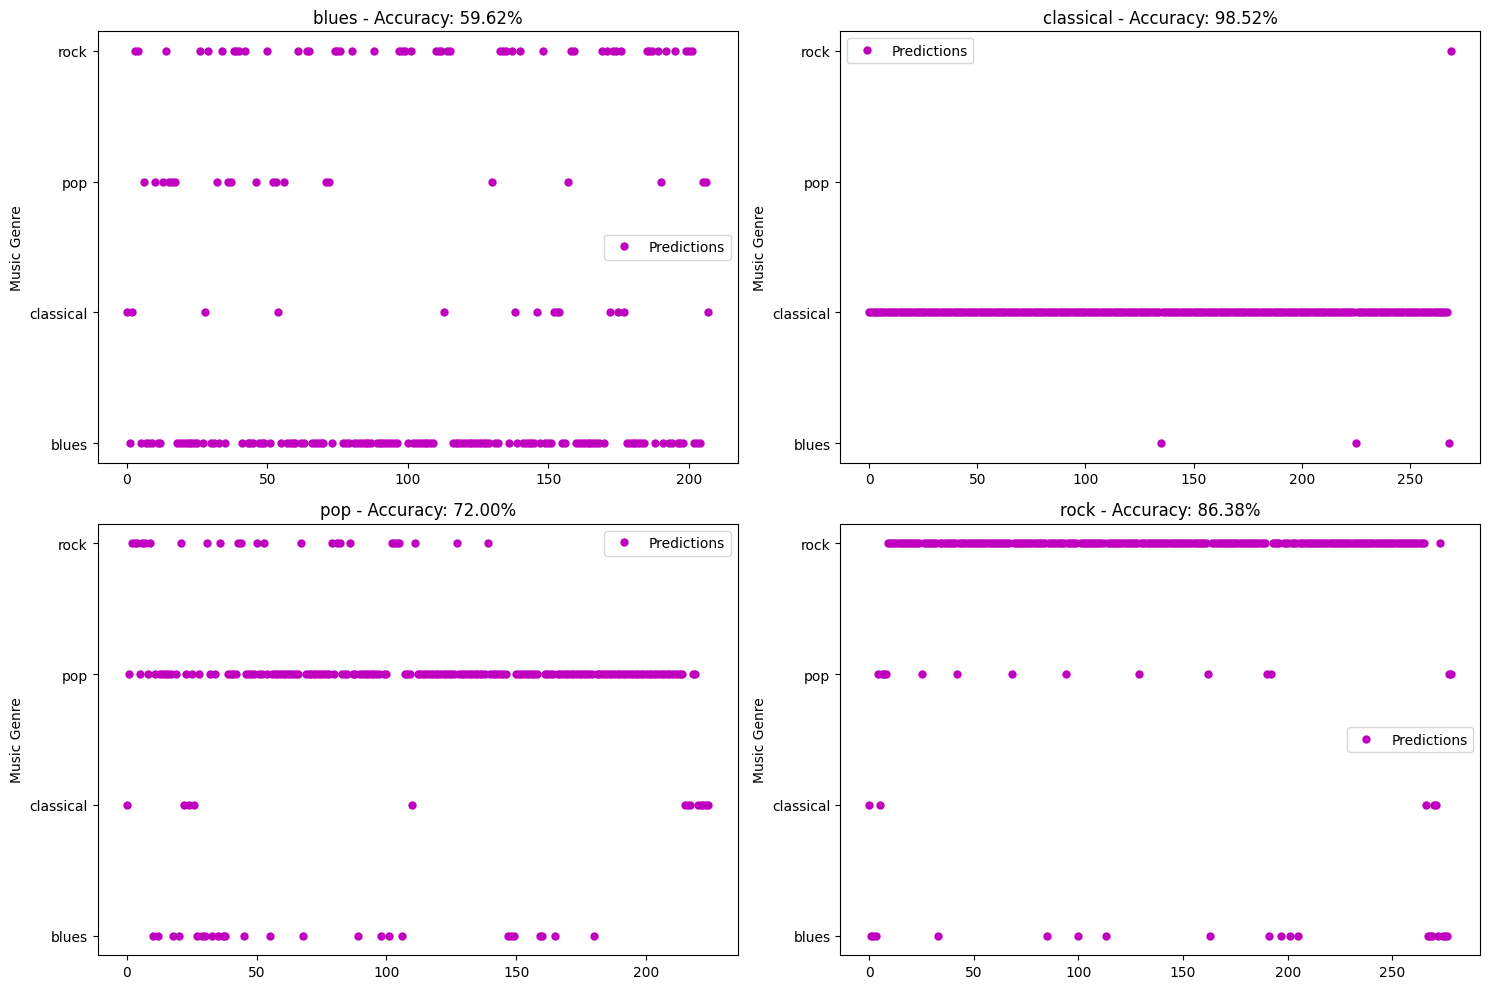

In [ ]:

def load_dataset(filename, label_value):
    data = np.load(filename)
    labels = np.full(len(data), label_value)
    return data, labels

def process_and_plot_datasets(dataset_files, model):
    all_predictions = []
    accuracy_scores = []

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    genre_names = ["blues", "classical", "pop", "rock"]

    for i, (filename, label_value) in enumerate(dataset_files):
        data, labels = load_dataset(filename, label_value)
        dataset = Melgrams_Dataset(data, labels)
        loader = DataLoader(dataset=dataset, batch_size=16, shuffle=False)

        # predict
        predictions = predict(loader, model)
        all_predictions.append(predictions)

        # accuracy
        accuracy = accuracy_score(labels, predictions)
        accuracy_scores.append(accuracy)

        # plot
        row, col = divmod(i, 2)
        ax = axs[row, col]
        labels_dict = {0: "blues", 1: "classical", 2: "pop", 3: "rock"}
        ylabels = [labels_dict[i] for i in range(len(labels_dict))]
        x = range(len(predictions))
        ax.plot(x, predictions, "mo", markersize=5, label='Predictions')
        ax.set_title(f"{genre_names[i]} - Accuracy: {accuracy:.2%}")
        ax.set_ylabel("Music Genre")
        ax.set_yticks(range(len(labels_dict)))
        ax.set_yticklabels(ylabels)
        ax.legend()

    plt.tight_layout()
    plt.show()

# file names
datasets = [
    ("blues_0_melgrams.npy", 0),
    ("classic_1_melgrams.npy", 1),
    ("pop_2_melgrams.npy", 2),
    ("rock_3_melgrams.npy", 3)
]

process_and_plot_datasets(datasets, trained_model_test)


Βλεπουμε οτι οι προβλεψεις ανα ενα δευτερολεπτο του τραγουδιου ειναι αρκετα καλες εφοσον σε πολλες συνολικα ειναι αρκετα υψηλες αλλα γενικα πανω απο 50 % που σημαινει οτι το μουσικο ειδος εχει προβλευτει σωστα απο το μοντελο μας.